# Going Deeper -- the Mechanics of PyTorch (Part 1/3)

## The key features of PyTorch
- It uses dynamic computational graphs, which have the advantage of being more flexible
compared to its static counterparts.
- Dynamic computational graphs are debugging friendly: PyTorch
allows for interleaving the graph declaration and graph evaluation steps.
- We can execute the code
line by line while having full access to all variables. This is a very important feature that makes the
development and training of NNs very convenient.

## PyTorch's computation graphs
- PyTorch performs its computations based on a directed acyclic graph (DAG).

- The computation graph is simply a network of nodes. Each node resembles an operation, which applies a function to its input tensor or tensors and returns zero or more tensors as the
output.
- PyTorch builds this computation graph and uses it to compute the gradients accordingly.



### Creating a graph in PyTorch
Let’s create a graph in PyTorch for evaluating
z = 2×(a–b)+c, as shown in the previous figure. The variables a, b, and c are scalars (single numbers),
and we define these as PyTorch tensors.


In [1]:
import torch

In [2]:
def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


PyTorch functions such as add, sub (or subtract), and mul (or multiply) also
allow us to provide inputs of higher ranks in the form of a PyTorch tensor object. In the following code
example, we provide scalar inputs (rank 0), as well as rank 1 and rank 2 inputs, as list.

## PyTorch Tensor objects for storing and updating model parameters

In PyTorch,
a special tensor object for which gradients need to be computed allows us to store and update the parameters of our models during training. Such a tensor can be created by just assigning requires_grad
to True on user-specified initial values.

In [3]:
a = torch.tensor(3.14, requires_grad=True)
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(a)
print(b)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


In [4]:
a.requires_grad

True

In [5]:
w = torch.tensor([1.0, 2.0, 3.0])

print(w.requires_grad)

False


In [6]:
w.requires_grad_()

print(w.requires_grad)

True


method`_`() is an in-place method in PyTorch that is used for operations without making
a copy of the input.

For NN models, initializing model parameters with random weights is necessary to
break the symmetry during backpropagation—otherwise, a multilayer NN would be no more useful
than a single-layer NN like logistic regression.

When creating a PyTorch tensor, we can also use a
random initialization scheme. PyTorch can generate random numbers based on a variety of probability distributions

#### Xavier (or Glorot) initialization
- We can create a tensor with **Glorot** initialization, which is a classic random initialization scheme that was proposed by Xavier Glorot and Yoshua Bengio.

-  The general
idea behind Xavier initialization is to roughly balance the variance of the gradients across
different layers. Otherwise, some layers may get too much attention during training while
the other layers lag behind.

In [7]:
import torch.nn as nn

torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)


tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [8]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)


## Computing gradients via automatic differentiation and GradientTape

PyTorch supports automatic differentiation, which can be thought of as an implementation of the chain
rule for computing gradients of nested functions.

### Computing the gradients of the loss with respect to trainable variables

To compute these gradients, we can call the backward method from
the torch.autograd module. It computes the sum of gradients of the given tensor with regard to leaf
nodes (terminal nodes) in the graph.

let's compute $z=wx+b$ and define the loss as the squared
loss between the target y and prediction z,  $Loss = (y–z)^2$.

In [9]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])


z = torch.add(torch.mul(w, x), b)

loss = (y-z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)


dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [10]:
# verifying the computed gradient dL/dw
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


## Simplifying implementations of common architectures via the torch.nn module



### Implementing models based on nn.Sequential
With nn.Sequential, the layers stored inside the model are connected in a cascaded way.

In [11]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model


Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

We specified the layers and instantiated the model after passing the layers to the nn.Sequential class.
- The output of the first fully connected layer is used as the input to the first ReLU layer.
- The output of
the first ReLU layer becomes the input for the second fully connected layer.
- Finally, the output of the
second fully connected layer is used as the input to the second ReLU layer.

#### Configuring layers

 * Initializers `nn.init`: https://pytorch.org/docs/stable/nn.init.html
 * L1 Regularizers `nn.L1Loss`: https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
 * L2 Regularizers `weight_decay`: https://pytorch.org/docs/stable/optim.html
 * Activations: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity  


In [12]:
nn.init.xavier_uniform_(model[0].weight)

l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()


Here, we initialized the weight of the first linear layer with Xavier initialization. And we computed
the L1 norm of the weight of the second linear layer.

#### Compiling a model

 * Optimizers `torch.optim`:  https://pytorch.org/docs/stable/optim.html#algorithms
 * Loss Functions `tf.keras.losses`: https://pytorch.org/docs/stable/nn.html#loss-functions


Regarding the choices for optimization algorithms, SGD and Adam are the most widely used methods.

The choice of loss function depends on the task; for example, we might use mean square error loss
for a regression problem.

The family of cross-entropy loss functions supplies the possible choices for classification tasks.

let's use the SGD optimizer, and cross-entropy loss for binary classification

In [13]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Solving an XOR classification problem

The XOR classification problem is a classic problem for analyzing the capacity of a model with regard
to capturing the nonlinear decision boundary between two classes.

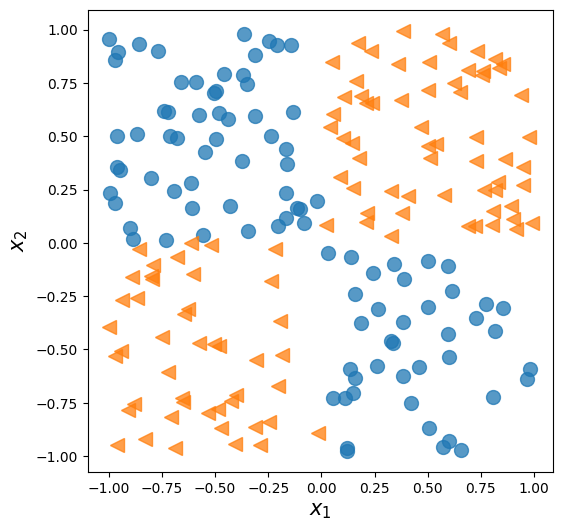

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0],
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0],
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

plt.show()

In [15]:
from torch.utils.data import DataLoader, TensorDataset


train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)


As
a general rule of thumb, the more layers we have, and the more neurons we have in each layer, the
larger the capacity of the model will be.

Here, the model capacity can be thought of as a measure of
how readily the model can approximate complex functions.

While having more parameters means
the network can fit more complex functions, larger models are usually harder to train (and prone to
overfitting).

In practice, it is always a good idea to start with a simple model as a baseline, for example,
a single-layer NN like logistic regression

In [16]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model


Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [17]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [18]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

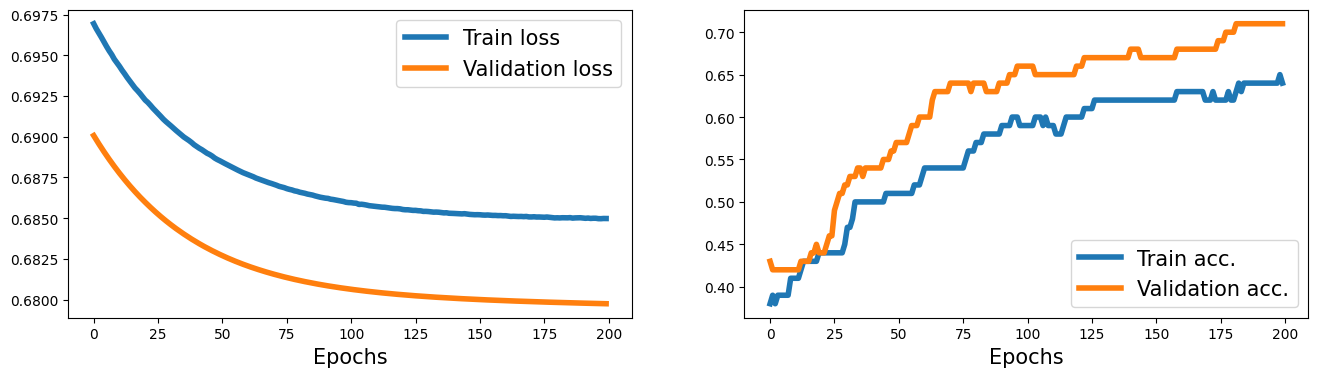

In [19]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

plt.show()

As we can see, a simple model with no hidden layer can only derive a linear decision boundary, which
is unable to solve the XOR problem. As a consequence, we can observe that the loss terms for both the
training and the validation datasets are very high, and the classification accuracy is very low.

---
#### Solution?
- To derive a nonlinear decision boundary, we can add one or more hidden layers connected via nonlinear
activation functions.

- The universal approximation theorem states that a feedforward NN with a single
hidden layer and a relatively large number of hidden units can approximate arbitrary continuous functions relatively well.

- Thus, one approach for tackling the XOR problem more satisfactorily is to add a
hidden layer and compare different numbers of hidden units until we observe satisfactory results on
the validation dataset.

- Adding more hidden units would correspond to increasing the width of a layer.

- Alternatively, we can also add more hidden layers, which will make the model deeper.
- The advantage
of making a network deeper rather than wider is that fewer parameters are required to achieve a
comparable model capacity.

- However, a downside of deep (versus wide) models is that deep models are prone to vanishing and
exploding gradients, which make them harder to train.

---

Let's feedforward NN with two hidden layers

In [20]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [21]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

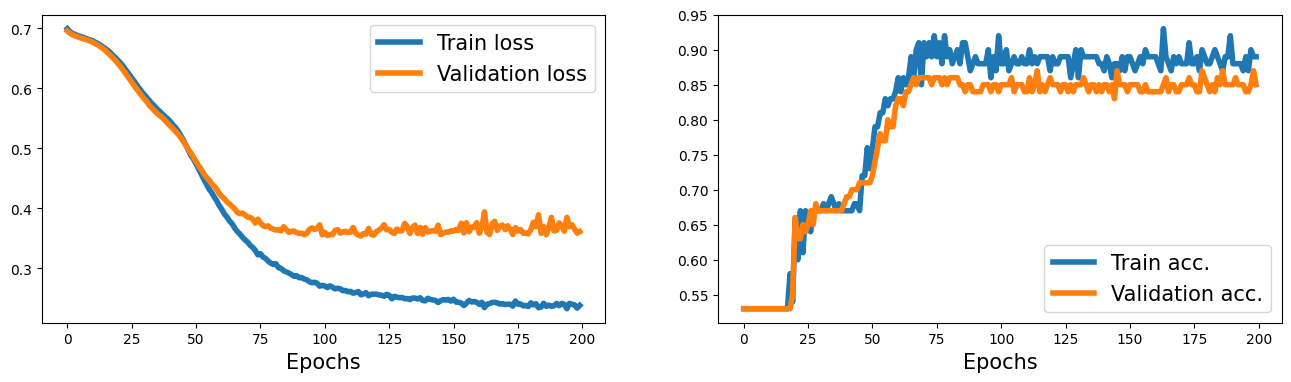

In [22]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

plt.show()

Now, we can see that the model is able to derive a nonlinear decision boundary for this data, and the
model reaches 90 percent accuracy on the training dataset. The validation dataset’s accuracy is 85
percent, which indicates that the model is slightly overfitting.

## Making model building more flexible with nn.Module

---
- we used the PyTorch Sequential class to create a fully connected NN with
multiple layers.
- This is a very common and convenient way of building models. However, it unfortunately doesn’t allow us to create more complex models that have multiple input, output, or intermediate
branches. That’s where nn.Module comes in handy.
---
The alternative way to build complex models is by subclassing nn.Module.

- In this approach, we create a
new class derived from nn.Module and define the method, __init__(), as a constructor.
- The forward()
method is used to specify the forward pass.
- In the constructor function, __init__(), we define the
layers as attributes of the class so that they can be accessed via the self reference attribute.
- Then, in
the forward() method, we specify how these layers are to be used in the forward pass of the NN.

---


In [23]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

model = MyModule()
model


MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [24]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [25]:
# !pip install mlxtend

we will use the `mlxtend` library to visualize the validation data and
the decision boundary.

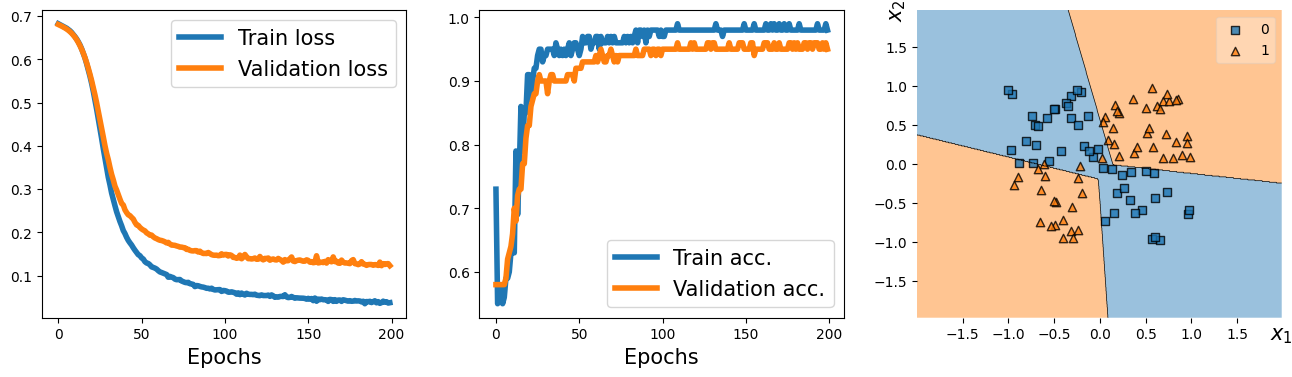

In [26]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(),
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

## Writing custom layers in PyTorch
In cases where we want to define a new layer that is not already supported by PyTorch, we can define
a new class derived from the nn.Module class. This is especially useful when designing a new layer or
customizing an existing layer.

we are going to define a new layer called NoisyLinear, which implements the computation $w(x+𝜖)+b$

In [27]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

In the constructor, we have added an argument, noise_stddev, to specify the standard deviation for
the distribution of 𝜖 , which is sampled from a Gaussian distribution.

Also, in the
forward() method, we have used an additional argument, training=False. We use it to distinguish
whether the layer is used during training or only for prediction (this is sometimes also called infer-
ence) or evaluation. Also, there are certain methods that behave differently in training and prediction
modes.

We also specified that the random vector, 𝜖, was to be generated and added to the input during training only and not used for inference or evaluation.

In [28]:
## testing:

torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)

x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))

print(noisy_layer(x, training=False))


tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


Now, let’s create a new model similar to the previous one for solving the XOR classification task.
As before, we will use the nn.Module class for model building, but this time, we will use our
NoisyLinear layer as the first hidden layer of the multilayer perceptron.

In [29]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [30]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

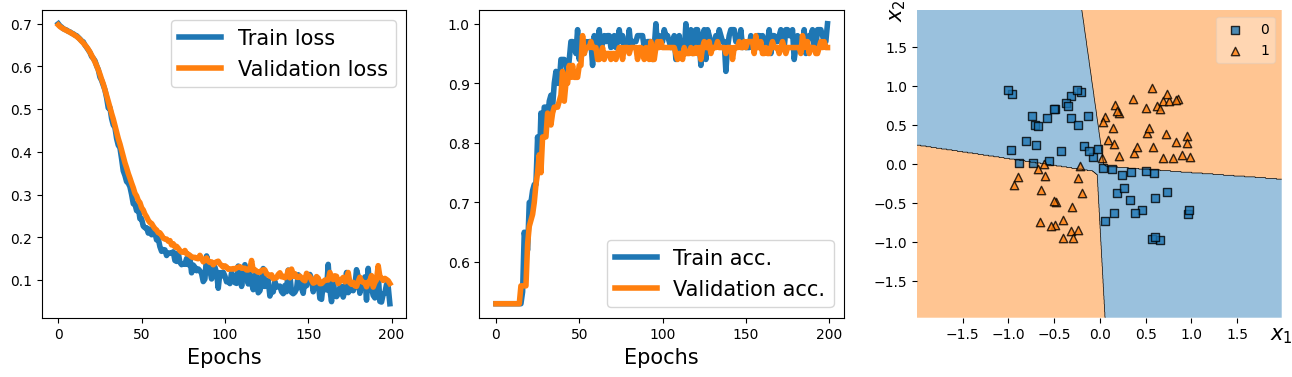

In [31]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(),
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

---
In general, writing a new customized
layer can be useful in other applications, for example, if you develop a new algorithm that depends
on a new layer beyond the existing ones.

---